# Fitting another self organizing map to in-game data

Consider the data points $x[t]$ in file `q3dm1-path1.csv` and fit another SOM into these data. This time, your self organizing map should again consists of $k = 24$ neurons but its structure should be that of two nested rings.

Once you have fitted your two-ring SOM, you can again determine how well its weights $w_1, . . . , w_k$ represent the data. To this end, compute the mean squared error E (MSE.

In [43]:
import csv
import numpy as np
import numpy.random as rnd 
import networkx as nx

In [44]:
def One_Ring_Inside_Other(matX, k):
    
    G1 = nx.generators.lattice.grid_2d_graph(int(k/2), 1, periodic=True)
    G1 = nx.convert_node_labels_to_integers(G1)
    G2 = nx.generators.lattice.grid_2d_graph(int(k/2), 1, periodic=True)
    G2 = nx.convert_node_labels_to_integers(G2)
    
    print(G1.nodes)
    print(G2.nodes)
    
    
    G =  nx.union(G1, G2, rename=('1-', '2-'))
    
    for i in range(int(k/2)):
        G.add_edge('1-'+str(i), '2-'+str(i))
    
    #print(int(k/2)+1, int(k/2)-1)
    
    #G.add_edge('1-0', '1-'+str(int(k/2))
    #G.add_edge('2-0', '2-'+str(int(k/2))
    
    m, n = matX.shape
    smpl = rnd.choice(n, k, replace=False)
    for i, v in enumerate(G):
        G.nodes[v]['w'] = matX[:,smpl[i]]
    
    print(G.nodes)

    return G

In [26]:
G = One_Ring_Inside_Other(matX, 24)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11']


<IPython.core.display.Javascript object>


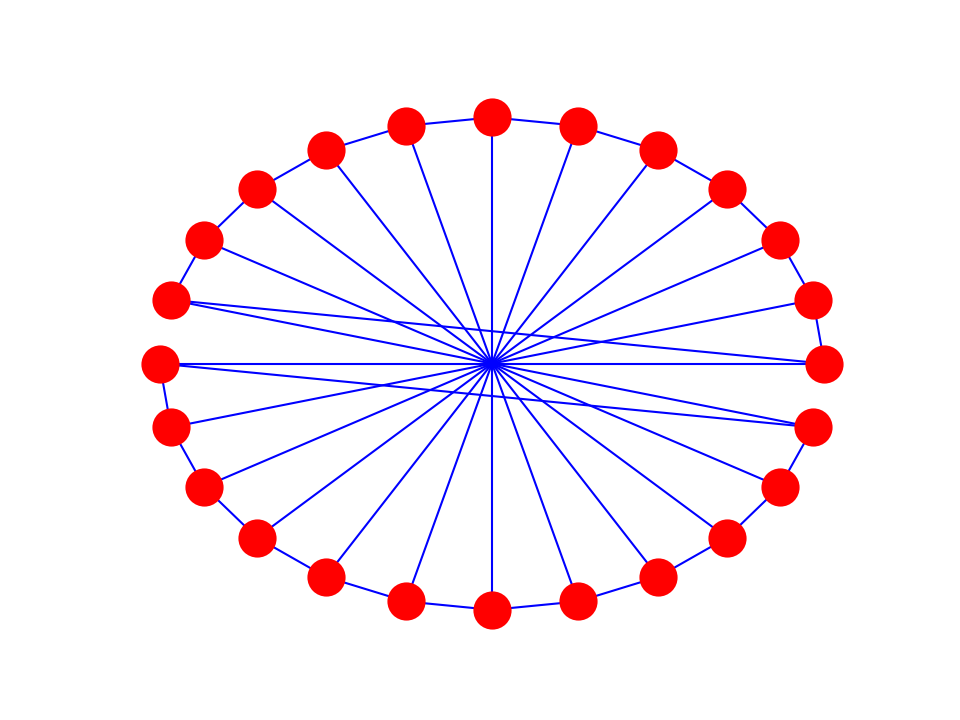

In [27]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.subplot(111)
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

In [45]:
def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1., k=20):
    m, n = matX.shape
    Giterx, Gitery, Giterz = [], [], []
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    # because this allows for easy squaring of its entries
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, n, size=tmax)
    
    for t in range(tmax):
        # sample a point x, i.e. a column of matrix X
        vecX = matX[:,smpl[t]]
        # determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        
        #
        xi, yi, zi = [], [], []
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.nodes[v]['w'] += eta * h * (vecX - G.nodes[v]['w'])
            xi.append(G.nodes[v]['w'][0]), yi.append(G.nodes[v]['w'][1]), zi.append(G.nodes[v]['w'][2])
        
        Giterx.append(xi), Gitery.append(yi), Giterz. append(zi)
        
    return G, Giterx, Gitery, Giterz

In [49]:
from numpy import linalg as LA
from scipy.spatial import distance

def compute_MSE(matX, weights):
    m, n = matX.shape
    
    print(n)
    E=np.zeros(n)
    #for w in weights.T:
    #    print('w', w)
    for t in range(n):
        E[t] = 1/n * np.min([distance.euclidean(matX[:, t], w)**2 for w in weights.T])
    print(print(np.around(np.sum(E), decimals=2)))
    return E

In [50]:
%matplotlib notebook
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time
import numpy.random as rnd 


def plot_SOM(data_path, k = 24, max_iter = 1000):
    x = []
    y = []
    z = []

    with open(data_path,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            x.append(float(row[0]))
            y.append(float(row[1]))
            z.append(float(row[2]))

    data = np.vstack((x,y,z))
    data.shape

    matX = data

    SOM1 = One_Ring_Inside_Other(matX, k)
    print(SOM1.nodes)

    fig = plt.figure()
    #fig.set_figheight(15)
    #fig.set_figwidth(15)
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()

    fig.show()
    fig.canvas.draw()

    ax.clear()

    SOM1, Gx, Gy, Gz = trainSOM(matX, SOM1, tmax = max_iter, k = k)
    computed_weights = np.asarray([Gx[max_iter-1], Gy[max_iter-1], Gz[max_iter-1]])
    #print('comp', computed_weights)
    
    compute_MSE(matX, computed_weights)
    nx.write_gpickle(SOM1, 'som.gpickle')
    
    ax.clear()
    iter = max_iter-1
    ax.scatter(matX[0, :] , matX[1, :], matX[2, :], color = "black", alpha=0.3, s = 1, label='The data first csv')

    ### add the points for plotting the structure
    f_p = np.asarray([Gx[int(iter)], Gy[int(iter)], Gz[int(iter)]]).T

    ax.plot(Gx[int(iter)][0:int(k/2)], Gy[int(iter)][0:int(k/2)], Gz[int(iter)][0:int(k/2)], 'o-', color = "blue", alpha=0.3, label='Two rings topology SOM')
    ax.plot(Gx[int(iter)][int(k/2):k], Gy[int(iter)][int(k/2):k], Gz[int(iter)][int(k/2):k], 'o-', color = "blue", alpha=0.3)

    for i in range(int(k/2)):
        ax.plot([f_p[i][0], f_p[i+int(k/2)][0]],[f_p[i][1], f_p[i+int(k/2)][1]], [f_p[i][2], f_p[i+int(k/2)][2]] , 'o-', color = "blue", alpha=0.3)

    ax.plot([f_p[0][0], f_p[int(k/2)-1][0]],[f_p[0][1], f_p[int(k/2)-1][1]], [f_p[0][2], f_p[int(k/2)-1][2]] , 'o-', color = "blue", alpha=0.3)    
    ax.plot([f_p[int(k/2)][0], f_p[k-1][0]],[f_p[int(k/2)][1], f_p[k-1][1]], [f_p[int(k/2)][2], f_p[k-1][2]] , 'o-', color = "blue", alpha=0.3)    


    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2 circles one inside other: iteration = '+str(iter))
    plt.legend()
    #plt.show()
    fig.canvas.draw()
    time.sleep(0.01)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11']
['1-0', '1-1', '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '2-0', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11']


<IPython.core.display.Javascript object>


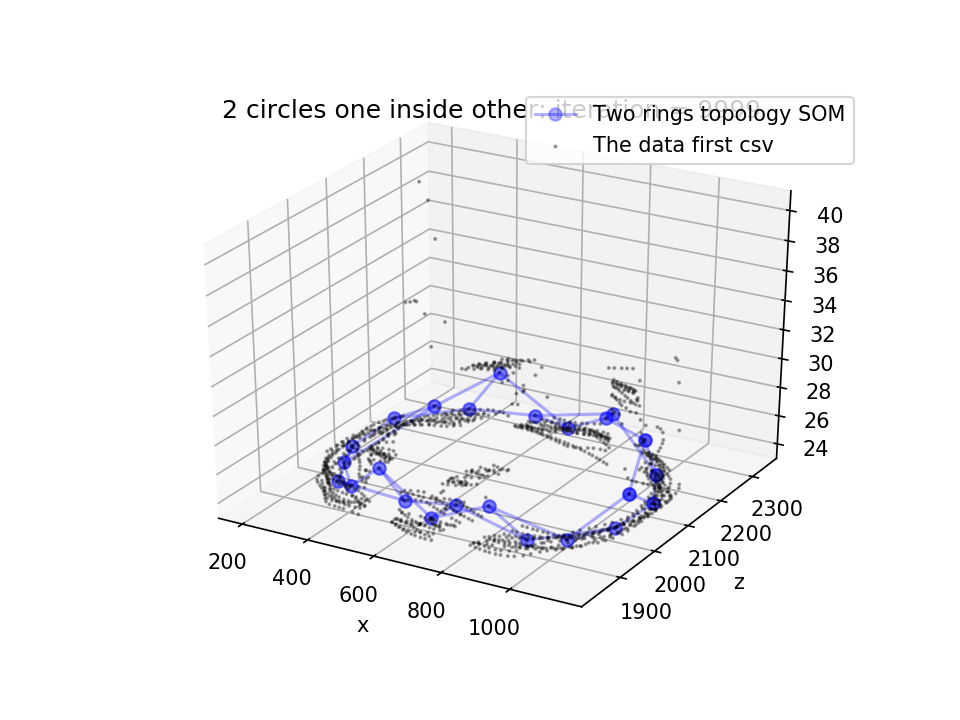

1327
1429.55
None


In [52]:
plot_SOM("q3dm1-path1.csv", max_iter = 10000)